# Кубический сплайн 32

### Импорт библиотек

In [1]:
import sympy as sym  # библиотека символьных вычислений
import numpy as np # библиотека для работы с массивами
import math  # для операции факториала, числа pi
import matplotlib.pyplot as plt  # для построения графиков
import pandas as pd  # для построения таблицы
from IPython.display import display  # для вывода таблицы

### Инициализация символьных переменных

In [2]:
x = sym.symbols('x')  # инициализировали символьные переменные
f = sym.Function('f')(x)  # инициализировали символьную функцию
# N = 1 - номер в списке группы
f = x - sym.sin(x) - 0.25  # определили функцию соответственно номеру в списке группы
a = 0
b = 10  # [a,b] - выбранный интервал интерполирования

### Определим функцию решения СЛАУ методом Гаусса
#### понадобится ниже
метод Гаусса устойчив для матрицы H, т.к. она трехдиагональная, диагонально доминирующая (симметрическая и положительно определенная).

In [3]:
def Gauss(A, b): # A - матрица (n,n), b - вектор (n,1)
    n=len(b)
    #прямой ход метода Гаусса
    for k in range(n): # строки
        # поиск максимума по столбцу
        max_index=0 # индекс максимума к-го столбца
        maxk=0  # максимум к-го столбца
        for i in range(k, n): # столбцы
            if (maxk<abs(A[i][k])):
                    max_index=i
                    maxk=abs(A[i][k])
        #нашли индекс максимума, теперь меняем строки
        Cb=b[k]
        b[k]=b[max_index]
        b[max_index]=Cb
        
        C=A[k]
        A[k]=A[max_index]
        A[max_index]=C  
        #
        # нормируем строку
        b[k]=b[k]/A[k][k]
        A[k]=[A[k][x]/A[k][k] for x in range(n)] 
        # преобразуем последующие n-k строк
        for m in range(k+1, n):
            b[m]=b[m]-b[k]*A[m][k]
            A[m]=[A[m][x]-A[k][x]*A[m][k] for x in range(n)]            
        #
    #print('A=', np.array(A).round(4))
    #print('b=', np.array(b).round(4))
    
    # обратный ход метода Гаусса
    X=[0]*n # вектор неизвестных
    i=n
    while (i!=0):
        i-=1
        X[i]=b[i]
        for j in range(n-i-1):
            X[i]=X[i]-A[i][n-1-j]*X[i+1]
    return X

# Сплайн S_32
## На равноотстоящих узлах

функция возвращает вектор a=(a_11,a_10,a_21,a_20,...,a_n-1.1,a_n0)

In [17]:
def S_32(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)  
    #knots = list((b-a)/(n+1)*(i+1) for i in range(n))
    h = (b-a)/n  # т.к. равноотстоящие узлы
    
    # строим матрицу H, векторы y_1, y_2
    # где y_1 - вектор первых производных, y_2 - вектор вторых производных на отрезках интерполирования
    H = np.eye(n-2)*4*h
    for i in range(1, n-2):
        H[i][i-1] = h  # заполнили H, (h одно и то же) по формуле 5.2.24
        H[i-1][i] = h
    # заполним вектор гамма по формуле 5.2.23
    gamma = np.zeros(n-2)
    for i in range(1, n-1):
        gamma[i-1] = 6/h*(f.subs(x,knots[i+1])-2*f.subs(x,knots[i])+f.subs(x,knots[i-1]))
    # вычисляем вектор у_2
    y_2 = Gauss(H, gamma)  # решаем СЛАУ H*y_2=gamma методом Гаусса
    y_2 = np.append(0, y_2)  # y_2[0] = y_2[n-1] = 0 по условию
    y_2 = np.append(y_2, 0)
    # вычисляем вектор y_1 по формуле 5.2.25
    y_1 = np.zeros(n-1)
    for i in range(n-1):
        y_1[i] = (f.subs(x,knots[i+1])-f.subs(x,knots[i]))/h - y_2[i+1]*h/6 - y_2[i]*h/3
    # C - массив коэффициентов полиномов 
    C = np.zeros(4*(n-1))
    for i in range(n-1):
        Ci = sym.Function('Ci')(x)
        # Ci - полином на каждом отрезке разбиения, вычисляем по формуле 5.2.26
        Ci = (f.subs(x, knots[i]) + y_1[i]*(x-knots[i]) + y_2[i]*(x-knots[i])**2/2 + (y_2[i+1]-y_2[i])*(x-knots[i])**3/(6*h))
        coeffs = sym.poly(Ci).coeffs()  # вычленили коэффициенты полинома Ci
        for j in range(4):
            C[4*i+j] = coeffs[j]  # записали коэффициенты полинома Ci в общий вектор коэффициентов
    return C

In [18]:
S_32(5, f)

IndexError: list index out of range

## Функция поиска максимума отклонения
### на равноостоящих узлах

In [6]:
def RS(n, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)
    ans = S_32(n, f)  # сплайн 3,2, вектор коэффициентов
    m = 10*n  # количество точек разбиения
    r = []  # массив максимумов отклонений сплайна на отрезках [x_j,x_j+1]
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[4*j]*x**3 + ans[4*j+1]*x**2+ans[4*j+2]*x+ans[4*j+3]  # полином на отрезке [x_j,x_j+1]
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # массив разностей на отрезке [x_j,x_j+1]
        r.append(max(rj))  # присоединили максимальный на отрезке
    return max(r)

## Сплайн S_32 на оптимальных узлах

здесь hi на каждом отрезке разное

In [7]:
def S_32opt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()  # отсортировала, т.к. для вычисления h надо чтобы узлы были последовательно в массиве
    h = [knots[i]-knots[i-1] for i in range(1, n)] # вектор разностей (расстояний) между узлами
    
    # строим матрицу H, векторы у_1, y_2
    # где y_1 - вектор первых производных, y_2 - вектор вторых производных 
    H = np.eye(n-2)  # пока задали единичную матрицу
    for i in range(1, n-2):
        H[i-1][i-1]=2*(h[i-1]+h[i])  # заполняем H по формуле 5.2.24
        H[i][i-1] = h[i]
        H[i-1][i] = h[i]
    H[n-3][n-3] = 2*(h[n-3]+h[n-2])
    # заполним вектор гамма по формуле 5.2.23
    gamma = np.zeros(n-2)
    for i in range(1, n-1):
        gamma[i-1] = 6*((f.subs(x,knots[i+1])-f.subs(x,knots[i]))/h[i] - (f.subs(x,knots[i])-f.subs(x,knots[i-1]))/h[i-1])
    # вычислим вектор y_2
    y_2 = Gauss(H, gamma)  # решаем СЛАУ H*y_2=gamma методом Гаусса
    y_2 = np.append(0, y_2)  # y_2[0] = y_2[n-1] = 0 по условию
    y_2 = np.append(y_2, 0)
    # вычислим вектор y_1 по формуле 5.2.25
    y_1 = np.zeros(n-1)
    for i in range(n-1):
        y_1[i] = (f.subs(x,knots[i+1])-f.subs(x,knots[i]))/h[i] - y_2[i+1]*h[i]/6 - y_2[i]*h[i]/3
    # C - массив коэффициентов полиномов 
    C = np.zeros(4*(n-1))
    for i in range(n-1):
        # Ci - полином на каждом отрезке разбиения, вычисляем по формуле 5.2.26
        Ci = sym.Function('Ci')(x)
        Ci = (f.subs(x, knots[i]) + y_1[i]*(x-knots[i]) + y_2[i]*(x-knots[i])**2/2 + (y_2[i+1]-y_2[i])*(x-knots[i])**3/(6*h[i]))
        coeffs = sym.poly(Ci).coeffs()  # вычленили коэффициенты полинома Ci
        for j in range(4):
            C[4*i+j] = coeffs[j]  # записали коэффициенты полинома Ci в общий вектор коэффициентов
    return C

In [8]:
S_32opt(9, f)

array([ 2.23272511e-01, -3.65028706e-01,  4.92524645e-01, -4.19559566e-01,
       -1.05994790e-01,  1.08157369e+00, -1.62597552e+00,  6.14597654e-01,
       -1.65637195e-01,  1.57005348e+00, -2.95954855e+00,  1.82817023e+00,
        4.99292754e-02, -1.15761319e+00,  8.54527942e+00, -1.43469570e+01,
        1.73464026e-01, -3.30051084e+00,  2.09358829e+01, -3.82284919e+01,
       -9.99006612e-03,  7.00596770e-01, -8.15197934e+00,  3.22606337e+01,
       -1.84465649e-01,  5.16832353e+00, -4.62864126e+01,  1.40759883e+02,
        4.41742191e-02, -1.31706870e+00,  1.50331826e+01, -5.24997078e+01])

### Функция поиска максимума отклонения на оптимальных узлах

In [9]:
def RSopt(n, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()
    ans = S_32opt(n, f) 
    m = 10*n
    r = []  # массив отклонений ИПЛ в точках T
    for j in range(n-1):
        T = list((knots[j+1]-knots[j])/(m+1)*(i+1)+knots[j] for i in range(m))  # массив точек разбиения [a,b], в которых определяется отклонение
        Snj= ans[4*j]*x**3 + ans[4*j+1]*x**2+ans[4*j+2]*x+ans[4*j+3]  # полином на отрезке [x_j,x_j+1]
        rj = [abs(f.subs(x, ti) - Snj.subs(x, ti)) for ti in T]  # массив разностей на отрезке [x_j,x_j+1]
        r.append(max(rj))
    return max(r)

# Построение таблицы

In [10]:
df = pd.DataFrame({'n': [], 'm':[], 'RS32n': [], 'RS32optn':[]})  # для построения таблицы поведения S32 при увеличении количества узлов интерполирования
n_knots = [4, 6, 9, 20, 30, 50]
for n in n_knots:
    RS32= RS(n, f)  # максимум отклонения на равноотстоящих узлах
    RS32opt = RSopt(n,f)  # максимум отклонения на оптимальных узлах
    line = {'n': n, 'm': 10*n, 'RS32n':RS32, 'RS32optn':RS32opt}
    df = df.append(line, ignore_index=True)
display(df)

,n,m,RS32n,RS32optn
0,4.0,40.0,2.99339812492464,0.242182417667430
1,6.0,60.0,1.53277639623546,0.227427498949173
2,9.0,90.0,0.630241440911927,0.0286717110256482
3,20.0,200.0,0.0921439207176272,0.000931259375524185
4,30.0,300.0,0.0449017273997168,0.000182896230758622
5,50.0,500.0,0.0178383601196757,2.37858980209893e-5


# Построение графиков
## на равноотстоящих узлах

In [11]:
# для удобства определим функцию построения графика
def plot_spline(n, a, b, f):
    knots = [] # равноотстоящие узлы интерполирования
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)
    knots = list((b-a)/(n+1)*(i+1) for i in range(n))
    for i in range(n):
            xi = a + ((b-a)/(n-1))*i
            knots.append(xi)  
    for i in range(n-1):
        X = np.arange(knots[i], knots[i+1], 0.05)
        ans = S_32(n,f)
        qi = ans[4*i]*x**3 + ans[4*i+1]*x**2+ans[4*i+2]*x+ans[4*i+3]  # q_i = a_i3*x^3+a_i2*x^2+a_i1*x+a_i0
        lix = [qi.subs(x, xk) for xk in X]
        plt.plot(X, lix, '--', linewidth = 3)

Text(0.5, 1.0, 'График №1 S_32 n=5, n=10, n=30')

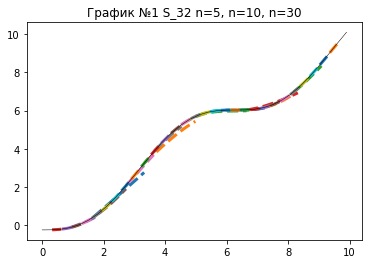

In [12]:
plt.figure()
x = sym.symbols('x')
li = sym.Function('li')(x)
ab = np.arange(a, b, 0.3)
fx = [f.subs(x, xi) for xi in ab]
plot_spline(5, 0, 10, f)
plot_spline(10, 0, 10, f)
plot_spline(30, 0, 10, f)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plt.title('График №1 S_32 n=5, n=10, n=30')

### Для наглядности так же в таком варианте 

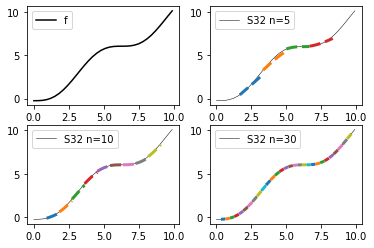

In [13]:
plt.figure(3)
plt.subplot(221)
plt.plot(ab, fx, 'k')
plt.legend('f(x)')
plt.subplot(222)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(5, 0, 10, f)
label = ['S32 n=5']
plt.legend(label)
plt.subplot(223)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(10, 0, 10, f)
label = ['S32 n=10']
plt.legend(label)
plt.subplot(224)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline(30, 0, 10, f)
label = ['S32 n=30']
plt.legend(label)

## на оптимальных узлах

In [14]:
# для удобства определим функцию построения графика
def plot_spline_opt(n, a, b, f):
    knots = list(((b-a)*sym.cos((2*i+1)*math.pi/(2*(n+1)))+b+a)/2 for i in range(n)) # оптимальные узлы интерполирования
    knots.sort()
    for i in range(n-1):
        X = np.arange(knots[i], knots[i+1], 0.05)
        ans = S_32opt(n,f)
        li = ans[4*i]*x**3 + ans[4*i+1]*x**2+ans[4*i+2]*x+ans[4*i+3] # l_i = a_i3*x^3+a_i2*x^2+a_i1*x+a_i0
        lix = [li.subs(x, xk) for xk in X]
        plt.plot(X, lix, '--', linewidth = 3)

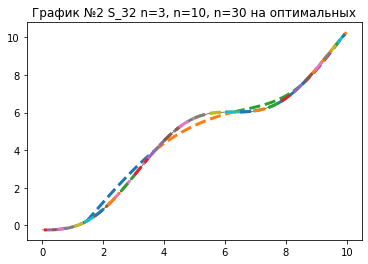

In [15]:
plt.figure(4)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plt.title('График №2 S_32 n=3, n=10, n=30 на оптимальных')
plot_spline_opt(5, 0, 10, f)
plot_spline_opt(10, 0, 10, f)
plot_spline_opt(30, 0, 10, f)

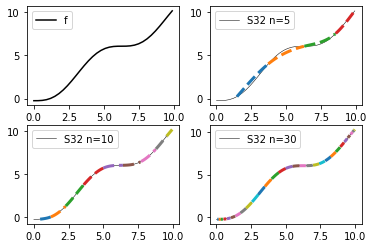

In [16]:
plt.figure(3)
plt.subplot(221)
plt.plot(ab, fx, 'k')
plt.legend('f(x)')
plt.subplot(222)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(5, 0, 10, f)
label = ['S32 n=5']
plt.legend(label)
plt.subplot(223)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(10, 0, 10, f)
label = ['S32 n=10']
plt.legend(label)
plt.subplot(224)
plt.plot(ab, fx, 'k', linewidth = 0.5)
plot_spline_opt(30, 0, 10, f)
label = ['S32 n=30']
plt.legend(label)